# Fixing Further Study Verbatim Notebook

## Import python modules

In [128]:
%matplotlib inline
import re                           # Regular Expressions
import nltk                         # Natural Language ToolKit
import pandas as pd                 # Python Data Analysis Library
import numpy as np                  # Numerical Python
import matplotlib.pyplot as plt     # Visualisation

## Get the data

Start with the survey data.

In [130]:
filePath = 'S:/RTOPI/Both Surveys/All Final Datasets/Datasets - 2019/StudentSurveys.csv'
df = pd.read_csv(filePath, encoding = 'ISO-8859-1')

We started asking students the name of the course they were studying in 2019, so restrict data to 2019 observations only.

Rows where the verbatim is not provided are also irrelevant, so let's remove these.

In [131]:
df = df[(df['SurveyYear'] == 'S2019') & (~pd.isna(df['s_fs_name_v']))]

### Select relevant fields
The fields that we need are:

* SurveyResponseID
* CourseID
* s_fs_lev
* level_description
* s_fs_name_v

In [132]:
df = df[['SurveyResponseID', 'CourseID', 's_fs_lev', 's_fs_name_v']]

The course level field is coded, but we actually need the course level description.

This will help check whether the verbatim contains the course level information, and if not, to add it in.

However, levels 5, 8 and 9 are ambiguous, and make it harder to check:

* 5 = vce or vcal
* 8 = bachelor or associate degree
* 9 = masters or PhD

For now, 8 is assigned "bachelor", as this is most common.

In [133]:
s_fs_lev_dict = {'s_fs_lev':          [1, 2, 3, 4, 5, 6, 7, 8, 9],
                 'level_description': ['certificate i', 'certificate ii',
                                       'certificate iii', 'certificate iv',
                                       'vce or vcal', 'diploma',
                                       'advanced diploma', 'bachelor', 'higher than a degree']}
s_fs_lev_dict = pd.DataFrame(s_fs_lev_dict)  # Turn into data frame in order to left join
s_fs_lev_dict

,s_fs_lev,level_description
0,1,certificate i
1,2,certificate ii
2,3,certificate iii
3,4,certificate iv
4,5,vce or vcal
5,6,diploma
6,7,advanced diploma
7,8,bachelor
8,9,higher than a degree


### Merge survey data with course level description

In [ ]:
df = pd.merge(df, s_fs_lev_dict, how = 'left')
df['s_fs_name_v'] = df['s_fs_name_v'].apply(lambda x: x.lower())
df

## Data exploration

The next step is to explore what are the common errors that we need to address.

Below shows that many respondents are putting in consistent information, but the problematic ones are where the verbatim has low counts:

* 'course' without reference to the course level
* inconsistent representation of 'certificate'
* use of Arabic numbers instead of the standard Roman numbers

(The first line of code below is why I find Python less intuitive than R)

In [134]:
counts = df['s_fs_name_v'].value_counts()[df['s_fs_name_v'].value_counts() > 1].rename_axis('s_fs_name_v').reset_index(name = 'n')
counts

,s_fs_name_v,n
0,Bachelor of Nursing,156
1,Bachelor of nursing,149
2,Diploma of Nursing,118
3,Diploma of nursing,99
4,Bachelor of Arts,65
...,...,...
1206,Bachelor of design,2
1207,Hospitality course,2
1208,Certificate IV in agriculture,2
1209,Advanced Diploma in Visual Arts,2


The histogram below shows that there are a LOOOOOOOT of course names with low counts, which we know are more likely to be error-prone.

(Again, this is where I find Python's default plotting library a bit weird. Calling DataFrame.plot implicitly creates an object, 'plt', rather than forcing this to be explicit)

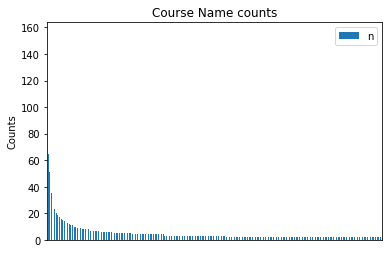

In [135]:
counts.plot(kind = 'bar')
x_axis = plt.axes().axes.get_xaxis()
x_axis.set_visible(False)
plt.title('Course Name counts')
plt.ylabel('Counts')
plt.xlabel('Course Name')
plt.show()

If we want to fix the problematic ones by inspecting them individually, this would take an unreasonable long time.

Therefore, we need another approach to fix words.

### Tokenize - splitting text into individual words
A standard approach to working with words is to 'tokenize' words, or splitting sentences into individual words.

This makes many things easier, such as identifying patterns, counting, cleaning words.

In [141]:
tokenized_df = df.copy()
tokenized_df['tokens'] = tokenized_df['s_fs_name_v'].apply(lambda x: nltk.word_tokenize(x))
tokenized_df[['SurveyResponseID', 's_fs_name_v', 'tokens']].head()

,SurveyResponseID,s_fs_name_v,tokens
164247,S000019,Associates degree of spatial science (surveyin...,"[Associates, degree, of, spatial, science, (, ..."
164265,S000091,Advanced Diploma of Screen and Media,"[Advanced, Diploma, of, Screen, and, Media]"
164268,S000096,Certificate 3 Visual Art,"[Certificate, 3, Visual, Art]"
164273,S000121,Equine science,"[Equine, science]"
164275,S000130,Diploma in Patisserie,"[Diploma, in, Patisserie]"


To operate on individual words, we need to convert the 'tokens' column into a column of individual *tokens*.

In [143]:
tokenized_df = tokenized_df.explode('tokens')
tokenized_df.head(9)

,SurveyResponseID,CourseID,s_fs_lev,s_fs_name_v,tokens
164247,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,Associates
164247,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,degree
164247,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,of
164247,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,spatial
164247,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,science
164247,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,(
164247,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,surveying
164247,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,major
164247,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,)


### Package this

The steps to prepare our data to this stage has been:

1. Left join course level description
2. Remove missing observations
3. Tokenize course verbatim
4. Convert to one-token-per-row

In order to make it easy to apply to a data set, we can pakage these steps into a function, called *tokenize*.

In [147]:
def tokenize(data = df, id = 'SurveyResponseID', col = 's_fs_name_v'):
    
    s_fs_lev_dict = {'s_fs_lev':          [1, 2, 3, 4, 5, 6, 7, 8, 9],
                     'level_description': ['certificate i', 'certificate ii',
                                           'certificate iii', 'certificate iv',
                                           'vce or vcal', 'diploma',
                                           'advanced diploma', 'bachelor', 
                                           'higher than a degree']}
    s_fs_lev_dict = pd.DataFrame(s_fs_lev_dict)

    data = pd.merge(data, s_fs_lev_dict, how = 'left')

    # tokenize
    data['tokens'] = data[col].apply(lambda x: nltk.word_tokenize(x))

    # convert to narrow data
    tokenized_df = data.explode('tokens')

    return(tokenized_df)


In [148]:
# df.columns
tokenize(data = df)

,SurveyResponseID,CourseID,s_fs_lev,s_fs_name_v,level_description,tokens
0,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,bachelor,Associates
0,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,bachelor,degree
0,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,bachelor,of
0,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,bachelor,spatial
0,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,bachelor,science
...,...,...,...,...,...,...
13219,S165523,22077VIC,4.0,Certificate 4 in Auslan,certificate iv,Auslan
13220,S165551,CHC33015,8.0,Bachelor of Social Work,bachelor,Bachelor
13220,S165551,CHC33015,8.0,Bachelor of Social Work,bachelor,of
13220,S165551,CHC33015,8.0,Bachelor of Social Work,bachelor,Social


### Misspelling

The Pareto principle (AKA the 80/20 rule) states that roughly 80% of effects come from 20% of the causes.

In this problem, most of the errors are probably attributable to a minority of spelling errors.

Specifically, misspelling of course types and levels.

**Bachelors**

It's amazing how many people report going onto studying a bachelors degree, but are unable to spell 'bachelor'.

To fix these errors, it seems quick to simply substitute words that match a particular pattern with the word 'bachelor'.

In [149]:
tokens = tokenized_df['tokens'].value_counts().rename_axis('word').reset_index(name = 'n')
tokens[tokens['word'].str.contains('bach')].head(10)

,word,n
84,bachelor,92
589,bachelors,10
2137,bach,1


In [150]:
tokens[tokens['word'].str.contains('batch')]

,word,n
2339,batchelor,1
2858,batch,1


In [151]:
tokens[tokens['word'].str.contains('bech')]

,word,n
2131,bechlor,1


In [152]:
tokens[tokens['word'].str.contains('bauc')]

,word,n


In [153]:
tokens[tokens['word'].str.contains('bch')]

,word,n


In [154]:
tokens[tokens['word'].str.contains('bah')]

,word,n


The fixes can be packaged into a function that takes in just a single argument, *string*. Creating functions allows data manipulation to be "modularised".

In [155]:
def fix_bachelor(string):
    string = re.sub(pattern = "^bac[a-z]*", repl = "bachelor", string = string)
    string = re.sub(pattern = "^bahelor$", repl = "bachelor", string = string)

    string = re.sub(pattern = "^batch$", repl = "bachelor", string = string)
    string = re.sub(pattern = "^batchler$", repl = "bachelor", string = string)

    string = re.sub(pattern = "^bauchor$", repl = "bachelor", string = string)
    string = re.sub(pattern = "^bechalor$", repl = "bachelor", string = string)
    string = re.sub(pattern = "^bechlor$", repl = "bachelor", string = string)
    string = re.sub(pattern = "^becholar$", repl = "bachelor", string = string)

    string = re.sub(pattern = "^bchelor$", repl = "bachelor", string = string)

    return(string)

In [156]:
fix_bachelor('bache')

'bachelor'

**Certificate**

Likewise "bachelor", there are many ways people spell the word "certificate".

Many variations are spelling errors, and others cutting short the 'certificate' into 'cert'. 

A perusal of these variations suggest that:

* Words that share the pattern 'cert#' should be split into 'certificate #' with a space.
* Words that begin with 'cert' should be replaced with the word 'certificate'

In [157]:
tokens[tokens['word'].str.contains('^cert')].head(10)

,word,n
31,cert,264
38,certificate,238
891,cert3,5
1093,cert4,4
1297,certification,3
1682,certificates,2
1745,cert.3,2
2580,cert111,1
2664,certificet,1
3367,certiii,1


However, some words beginning with 'cert' appear legitimate, such as 'certified' and 'certification'. Looking at the original verbatim should help decide how to deal with these.

Below, the course names that contain 'certified' are in fact spelt correctly, such as 'certified practicing accountant (cpa)', and should therefore not be 'corrected'.

However, this instance points to another problem: the CPA is not a bachelor degree! CA and CPA courses are graduate diplomas, even though they generally require to have a bachelor degree.

In [158]:
tokenized_df[tokenized_df['tokens'].str.contains('^certified')]

,SurveyResponseID,CourseID,s_fs_lev,s_fs_name_v,tokens


Courses using the word 'certification', on the other hand, are generally just incorrect spelling of 'certificate'.

(Except the last one...)

In [159]:
tokenized_df[tokenized_df['tokens'].str.contains('^certification')]

,SurveyResponseID,CourseID,s_fs_lev,s_fs_name_v,tokens
175006,S032801,CPC32413,10.0,level 1 IRATA international rope access certif...,certification
199451,S107816,BSB42015,8.0,Bachelor of Science. Done concurrently with th...,certification
207841,S133977,CHC30113,4.0,Education support certification,certification


Again, package this up into another function, and run some tests to make sure it's working.

In [160]:
def fix_certificate(string):
    if string != 'certified':
        string = re.sub(pattern = "^certi$", repl = "certificate i", string = string)
        string = re.sub(pattern = "^certii$", repl = "certificate ii", string = string)
        string = re.sub(pattern = "^certiii$", repl = "certificate iii", string = string)
        string = re.sub(pattern = "^certiv$", repl = "certificate iv", string = string)
        string = re.sub(pattern = "^cert1", repl = "certificate i", string = string)
        string = re.sub(pattern = "^cert11", repl = "certificate ii", string = string)
        string = re.sub(pattern = "^cert111", repl = "certificate iii", string = string)

        # Convert Arabic to Roman numbers
        # (mainly for certificates)
        string = re.sub(pattern = "1$", repl = "i", string = string)
        string = re.sub(pattern = "2$", repl = "ii", string = string)
        string = re.sub(pattern = "3$", repl = "iii", string = string)
        string = re.sub(pattern = "4$", repl = "iv", string = string)

        # Convert English to Roman numbers
        # (mainly for certificates)
        string = re.sub(pattern = "one", repl = "i", string = string)
        string = re.sub(pattern = "two", repl = "ii", string = string)
        string = re.sub(pattern = "three", repl = "iii", string = string)
        string = re.sub(pattern = "four", repl = "iv", string = string)

        string = re.sub(pattern = "1v", repl = "iv", string = string)

        # Remaining ways of spelling 'certificate'
        string = re.sub(pattern = "^cert[a-z]*", repl = "certificate", string = string)
        string = re.sub(pattern = "^cer$", repl = "certificate", string = string)

    return(string)

In [161]:
fix_certificate('certified')

'certified'

In [162]:
fix_certificate('cert ii')

'certificate ii'

In [163]:
fix_certificate('certiii')

'certificate iii'

In [164]:
fix_certificate('cert3')

'certificate'

**Diplomas and advanced diplomas**

Sometimes, people are just out to get you...

For those unique cases, just ignore them for now.

In [165]:
tokens[tokens['word'].str.contains('^dip')]

,word,n
16,diploma,484
384,dip,17
2461,diploma-,1
3170,diploma..,1
3517,diplomda,1
3773,diplomas,1
4097,diplomat,1
4392,diplomats,1


In [166]:
def fix_diploma(string):
    string = re.sub(pattern = "dip[a-z]*", repl = "diploma", string = string)

    return(string)
    
fix_diploma('diplomia')

'diploma'

In the case of advanced diplomas, maybe just convert a few words, rather than pattern recognition:

* advance
* adv
* advancing
* advances
* advanved
* advans

In [167]:
tokens[tokens['word'].str.contains('^adv')]

,word,n
194,advanced,37
600,advance,10
1224,adv,3
1264,advertising,3
1509,advice,2
2042,adviser,1
4017,advances,1


In [168]:
def fix_advanced(string):
    if string in ['advance', 'adv', 'advances', 'advanved', 'advans', 'advan']:
        return('advanced')
    else:
        return(string)

fix_advanced('advan')

'advanced'

**Associate degree**

In [169]:
tokens[tokens['word'].str.contains('^asso[a-z]')]

,word,n
901,associate,5
4403,associates,1


In [170]:
def fix_associate(string):
    string = re.sub(pattern = '^asso[a-z]', repl = 'associate', string = string)

    return(string)

### Other spelling errors


In [171]:
def fix_parentheses(string):
    string = re.sub(pattern = "\( ", repl = "(", string = string)
    string = re.sub(pattern = " \)", repl = ")", string = string)
    
    return(string)

## Putting it all together

To this stage, many small functions have been created.

They can be put together into a larger function.

In [172]:
def fix_fs_name_v(dataframe, id = 'SurveyResponseID', col = 's_fs_name_v'):
    # Tokenize s_fs_name_v column
    tokenized_df = tokenize(dataframe, id = id, col = col)

    # Fix words
    tokenized_df['tokens2'] = tokenized_df['tokens'].apply(fix_bachelor)

    # Join tokens together again
    df_fixed = tokenized_df.groupby([id, col])['tokens2'].apply(' '.join).reset_index(name = 's_fs_name_v_fixed')

    # Fix spaces before and after parentheses
    df_fixed['s_fs_name_v_fixed'] = df_fixed['s_fs_name_v_fixed'].apply(fix_parentheses)

    return(df_fixed)

In [174]:
temp = fix_fs_name_v(dataframe = df, id = 'SurveyResponseID', col = 's_fs_name_v')
temp = pd.merge(df, temp)
temp

,SurveyResponseID,CourseID,s_fs_lev,s_fs_name_v,s_fs_name_v_fixed
0,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...,Associates degree of spatial science (surveyin...
1,S000091,CUA51015,7.0,Advanced Diploma of Screen and Media,Advanced Diploma of Screen and Media
2,S000096,CUA20715,3.0,Certificate 3 Visual Art,Certificate 3 Visual Art
3,S000121,RGR40108,8.0,Equine science,Equine science
4,S000130,SIT40716,6.0,Diploma in Patisserie,Diploma in Patisserie
...,...,...,...,...,...
13216,S165505,FNS50615,6.0,Diploma of financial planning,Diploma of financial planning
13217,S165509,AHC41016,4.0,Agriculture,Agriculture
13218,S165510,HLT51612,8.0,Bachelor of nursing,Bachelor of nursing
13219,S165523,22077VIC,4.0,Certificate 4 in Auslan,Certificate 4 in Auslan


In [175]:
df

,SurveyResponseID,CourseID,s_fs_lev,s_fs_name_v
164247,S000019,CPP50116,8.0,Associates degree of spatial science (surveyin...
164265,S000091,CUA51015,7.0,Advanced Diploma of Screen and Media
164268,S000096,CUA20715,3.0,Certificate 3 Visual Art
164273,S000121,RGR40108,8.0,Equine science
164275,S000130,SIT40716,6.0,Diploma in Patisserie
...,...,...,...,...
218197,S165505,FNS50615,6.0,Diploma of financial planning
218199,S165509,AHC41016,4.0,Agriculture
218200,S165510,HLT51612,8.0,Bachelor of nursing
218204,S165523,22077VIC,4.0,Certificate 4 in Auslan
